<div class="alert alert-info">
<h1>How Do Changes in Calibration and Image Processing Affect Results?</h1>
Robert S. French, rfrench@seti.org - Last updated April 25, 2023

<h2>The Problem</h2>

<ol><li> French (2012) used inconsistently-calibrated images. Observations through ISS_041RF_FMOVIE001_VIMS
   used CISSCAL 3.3. Observations after that used CISSCAL 3.6. The current work uses CISSCAL 4.0beta.</li>
   
<li>French (2012) used radial extents from 138,465-141,835. The current work uses 139,223-141,223.</li>

<li>French (2012) used old image processing software to take one radial slice per image. 
   <ul>
      <li>The slice was taken at the point of least ring curvature and covered an inconsistent amount of longitude.
           The EW for an entire observations was the mean (+/- std dev) of those radial slices.</li>
      <li>The normal EW was computed by applying a single mean emission angle to all radial slices in an observation.</li>
      <li>The current work uses image reprojection and mosaicing to create a rectangular grid of longitude/radius.
          This process could potentially introduce changes in photometry.</li>
      <li>Longitudes are sampled at intervals of 0.02 degrees. The EW for an entire observation is the mean
          (+/- std dev) of these radial slices.</li>
      <li>The normal EW is computed on a slice-by-slice basis by looking at the emission angle for that particular
          slice.</li>
      <li>There are many more radial slices than in French (2012), resulting in more thorough coverage of the
          variability of the ring.</li>
    </ul>
    </li>
    </ol>
    
<h2>Methodology</h2>

Compare French (2012) to Current Data
<ul>
    <li>Use the same 25 F ring observations used in 2012.</li>
    <li>Compare the EWs between French (2012) results and current results.</li>
    <li>Use individual images to check on calibration differences with different versions.</li>
    <li>Apply those differences to the data to see if changes in calibration totally account for measurement differences.</li>
    <li>To check on the photometric accuracy of reprojections, try various combinations of radius and longitude
        zoom during reprojection.</li>
</ul>
</div>

# Read Data and Initialize Data Structures

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from f_ring_util.f_ring import (add_cisscal_ratios,
                                add_hover,
                                find_common_data_2012,
                                read_cassini_ew_stats)

%matplotlib notebook

In [2]:
# Read the new data and populate the old data
obsdata = read_cassini_ew_stats('../data_files/cass_ew_60_0.csv')

# Find the intersection of the old and new data
commondata = find_common_data_2012(obsdata)

# Add CISSCAL ratios
commondata = add_cisscal_ratios(commondata)

** SUMMARY STATISTICS - ../data_files/cass_ew_60_0.csv **
Unique observation names: 155
Total slices: 155
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 16:31:39
Total number of new observation names: 155
Total number of observation names from 2012: 25
Number of observation names in common: 23
Missing observation names: {'ISS_007RI_LPHRLFMOV001_PRIME', 'ISS_036RF_FMOVIE002_VIMS'}


# Compare French (2012) EWs with Current EWs

In [3]:
# Extract measurements from each CISSCAL version range
commondata33 = commondata.loc[:'ISS_041RF_FMOVIE002_VIMS']
commondata36 = commondata.loc['ISS_044RF_FMOVIE001_VIMS':]
print('CISSCAL 3.6 starts at', commondata.loc['ISS_044RF_FMOVIE001_VIMS']['Date'])
print('Number of CISSCAL 3.3 observations:', len(commondata33))
print('Number of CISSCAL 3.6 observations:', len(commondata36))

CISSCAL 3.6 starts at 2007-05-05 04:51:11
Number of CISSCAL 3.3 observations: 12
Number of CISSCAL 3.6 observations: 11


<IPython.core.display.Javascript object>


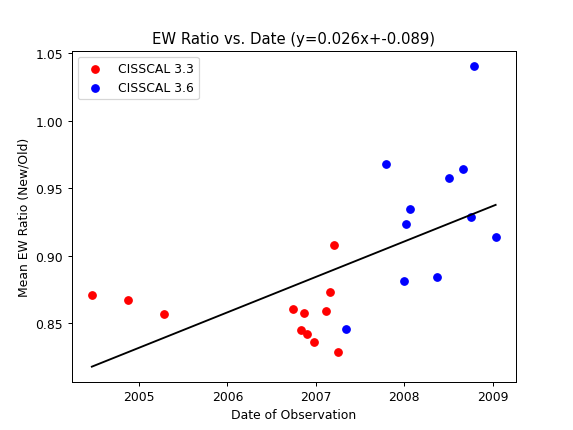

In [4]:
plt.figure()
coeff = np.polyfit(commondata['Date_days'], commondata['EW Mean Ratio'], 1)
date_min = commondata['Date_days'].min()
date_max = commondata['Date_days'].max()
plt.plot([date_min,date_max], np.polyval(coeff, [date_min,date_max]), '-',
         color='black')
p1 = plt.scatter(commondata33['Date'], commondata33['EW Mean Ratio'], 
                 color='red', label='CISSCAL 3.3')
p2 = plt.scatter(commondata36['Date'], commondata36['EW Mean Ratio'], 
                 color='blue', label='CISSCAL 3.6')
add_hover(commondata33, p1, commondata36, p2)
plt.legend(loc='upper left')
plt.xlabel('Date of Observation')
plt.ylabel('Mean EW Ratio (New/Old)')
_=plt.title(f'EW Ratio vs. Date (y={coeff[0]*365.25:.3f}x+{coeff[1]:.3f})')

In [5]:
print('How much was EW affected by CISSCAL version?')
c33_mean = commondata33['EW Mean Ratio'].mean()
c36_mean = commondata36['EW Mean Ratio'].mean()
overall_mean = commondata['EW Mean Ratio'].mean()
print(f'  CISSCAL 3.3 obs only - Mean New/Old EW: {c33_mean:.3f}')
print(f'  CISSCAL 3.6 obs only - Mean New/Old EW: {c36_mean:.3f}')
print(f'              All Data - Mean New/Old EW: {overall_mean:.3f}')

How much was EW affected by CISSCAL version?
  CISSCAL 3.3 obs only - Mean New/Old EW: 0.859
  CISSCAL 3.6 obs only - Mean New/Old EW: 0.931
              All Data - Mean New/Old EW: 0.893


<div class="alert alert-info">
<h2>Conclusion</h2>

<b>EWs based on images calibrated with CISSCAL 4.0 will appear ~10% *dimmer* than EWs based on previously calibrated images. Since we measured
a brightening in the F ring using previous versions of CISSCAL, that amount of brightening will now be less.
The difference in CISSCAL versions shows a distinct time dependence, with CISSCAL 3.3 being more distant from the new 4.0 and the more recent 3.6 converging on the new 4.0.</b>
</div>

# Compare Individual Images Calibrated with CISSCAL 3.3/3.6 to 4.0

<IPython.core.display.Javascript object>


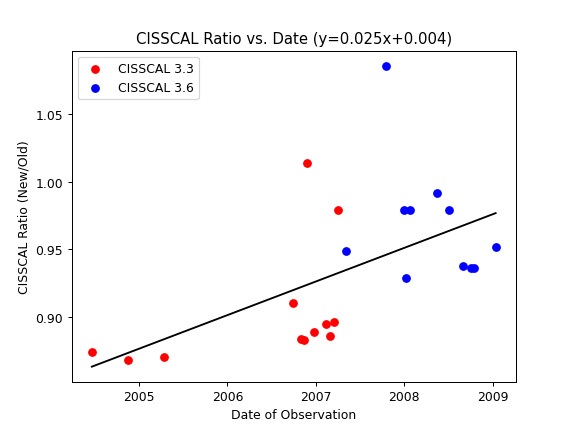

In [6]:
plt.figure()
coeff = np.polyfit(commondata['Date_days'], commondata['CISSCAL Ratio'], 1)
date_min = commondata['Date_days'].min()
date_max = commondata['Date_days'].max()
plt.plot([date_min,date_max], np.polyval(coeff, [date_min,date_max]), '-',
         color='black')
p1 = plt.scatter(commondata33['Date'], commondata33['CISSCAL Ratio'],
                 color='red', label='CISSCAL 3.3')
p2 = plt.scatter(commondata36['Date'], commondata36['CISSCAL Ratio'],
                 color='blue', label='CISSCAL 3.6')
add_hover(commondata33, p1, commondata36, p2)
plt.legend(loc='upper left')
plt.xlabel('Date of Observation')
plt.ylabel('CISSCAL Ratio (New/Old)')
_=plt.title(f'CISSCAL Ratio vs. Date (y={coeff[0]*365.25:.3f}x+{coeff[1]:.3f})')

<div class="alert alert-info">
<h2>Conclusion</h2>
    
<b>The changes in CISSCAL when measured pixel-by-pixel on individual images show approximately the same time dependence as the changes in EW above.</b>
</div>

# Compare 2012 EWs Adjusted for CISSCAL Ratios to Current EWs

<IPython.core.display.Javascript object>


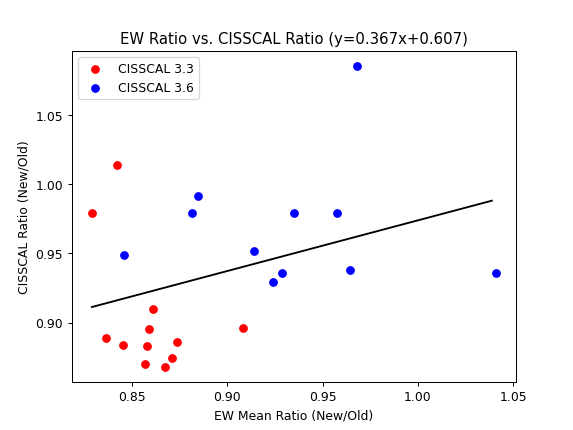

In [7]:
plt.figure()
coeff = np.polyfit(commondata['EW Mean Ratio'], commondata['CISSCAL Ratio'], 1)
ewr_min = commondata['EW Mean Ratio'].min()
ewr_max = commondata['EW Mean Ratio'].max()
p1 = plt.scatter(commondata33['EW Mean Ratio'], commondata33['CISSCAL Ratio'],
                 color='red', label='CISSCAL 3.3')
p2 = plt.scatter(commondata36['EW Mean Ratio'], commondata36['CISSCAL Ratio'],
                 color='blue', label='CISSCAL 3.6')
add_hover(commondata33, p1, commondata36, p2)
xrange = np.arange(ewr_min, ewr_max, 0.01)
plt.plot(xrange, np.polyval(coeff, xrange), '-', color='black')
plt.legend(loc='upper left')
plt.xlabel('EW Mean Ratio (New/Old)')
plt.ylabel('CISSCAL Ratio (New/Old)')
_=plt.title(f'EW Ratio vs. CISSCAL Ratio (y={coeff[0]:.3f}x+{coeff[1]:.3f})')

In [8]:
print('Answering the question: Does adjusting by the CISSCAL ratio fully account for the EW ratio?')
print('Looking at (EW_new / EW_2012) / (CISSCAL_new / CISSCAL_2012):')
cratio = (commondata['EW Mean Ratio']/commondata['CISSCAL Ratio']).mean()
cratio33 = (commondata33['EW Mean Ratio']/commondata33['CISSCAL Ratio']).mean()
cratio36 = (commondata36['EW Mean Ratio']/commondata36['CISSCAL Ratio']).mean()
print(f'  Mean all obs: {cratio:.3f}')
print(f'  Mean 3.3 obs: {cratio33:.3f}')
print(f'  Mean 3.6 obs: {cratio36:.3f}')

Answering the question: Does adjusting by the CISSCAL ratio fully account for the EW ratio?
Looking at (EW_new / EW_2012) / (CISSCAL_new / CISSCAL_2012):
  Mean all obs: 0.958
  Mean 3.3 obs: 0.953
  Mean 3.6 obs: 0.963


<IPython.core.display.Javascript object>


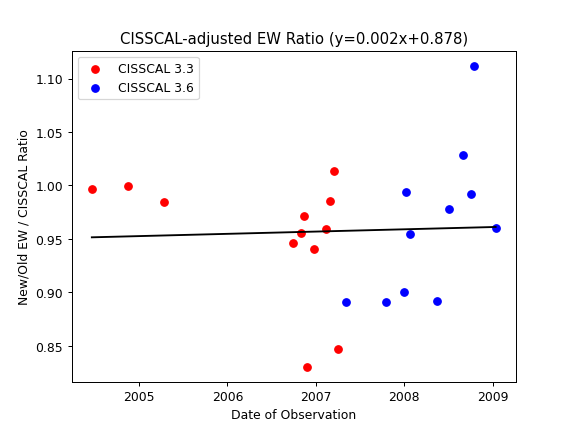

In [9]:
plt.figure()
coeff = np.polyfit(commondata['Date_days'],
                   commondata['EW Mean Ratio'] / commondata['CISSCAL Ratio'], 1)
date_min = commondata['Date_days'].min()
date_max = commondata['Date_days'].max()
p1 = plt.scatter(commondata33['Date'], commondata33['EW Mean Ratio'] / commondata33['CISSCAL Ratio'],
                 color='red', label='CISSCAL 3.3')
p2 = plt.scatter(commondata36['Date'], commondata36['EW Mean Ratio'] / commondata36['CISSCAL Ratio'],
                 color='blue', label='CISSCAL 3.6')
add_hover(commondata33, p1, commondata36, p2)
plt.plot([date_min,date_max], np.polyval(coeff, [date_min,date_max]), '-',
         color='black')
plt.legend()
plt.xlabel('Date of Observation')
plt.ylabel('New/Old EW / CISSCAL Ratio')
_=plt.title(f'CISSCAL-adjusted EW Ratio (y={coeff[0]*365.25:.3f}x+{coeff[1]:.3f})')

<div class="alert alert-info">
<h2>Conclusion</h2>
    
<b>EW Ratio and CISSCAL ratio are clearly correlated, as you would expect if the CISSCAL change was the primary
    driver of the EW change.</b>
<p>
<b>Once the 2012 EWs are adjusted for mean changes in CISSCAL, the EWs show no
    time dependence.</b>
<p>
<b>Adjusting for changes in CISSCAL ratio accounts for all but ~4% of the difference between 2012 and current
    EW data. This means that the changes in radial extent and reprojection/mosaicing should only account for a 4%
    difference, which is negligible.</b>
</div>

# Compare EWs Using Different Radial and Longitude Resolutions and Zooms

In [10]:
obsdata_by_res = {}
for rzoom in [1, 2, 5, 10]:
    for lzoom in [1, 2, 5, 10]:
        for rres in [2, 5, 10, 50]:
            for lres in [0.02, 0.10]:
                fn = f'../data_files/sensitivity/sens_ew_{rres}_{lres:4.2f}_{rzoom}_{lzoom}_0_0.csv' 
                try:
                    obsdata_by_res[(rres, lres, rzoom, lzoom)] = read_cassini_ew_stats(fn, use_obs_list=False, verbose=False)
                except FileNotFoundError:
                    print('Not found:', fn)
                except:
                    print('Other error:', fn)

In [11]:
agg_obsdata = pd.DataFrame()
for vers, res_obsdata in obsdata_by_res.items():
    if len(res_obsdata) == 0: continue
    sfx = f' {vers[0]:02d}/{vers[1]:4.2f}/{vers[2]:02d}/{vers[3]:02d}'
    agg_obsdata = agg_obsdata.join(res_obsdata[['Normal EW Mean']], how='outer', rsuffix=sfx)
agg_obsdata = agg_obsdata.transpose()
agg_obsdata = agg_obsdata.rename({'SENS_ISS_181RF_FMOVIE001_PRIME': '181RF_FMOVIE001',
                                  'SENS_ISS_181RF_FRINGPHOT001_VIMS': '181RF_FRINGPHOT001',
                                  'SENS_ISS_196RF_FMOVIE006_PRIME': '196RF_FMOVIE006'},
                                 axis='columns')
print(agg_obsdata.to_string())
print()
print('Min:')
print(agg_obsdata.min())
print('Max:')
print(agg_obsdata.max())
print('Fractional range (max-min)/min:')
print((agg_obsdata.max()-agg_obsdata.min())/agg_obsdata.min())

Observation                   181RF_FMOVIE001  181RF_FRINGPHOT001  196RF_FMOVIE006
Normal EW Mean                       0.698191            6.691736         6.527808
Normal EW Mean 02/0.10/01/01         0.692786            6.698702         6.520001
Normal EW Mean 05/0.02/01/01         0.700069            6.694809         6.534041
Normal EW Mean 05/0.10/01/01         0.689080            6.692360         6.520619
Normal EW Mean 10/0.02/01/01         0.700349            6.683739         6.532674
Normal EW Mean 10/0.10/01/01         0.686975            6.681082         6.523791
Normal EW Mean 50/0.02/01/01         0.562032            5.064646         6.315653
Normal EW Mean 50/0.10/01/01         0.560566            5.066958         6.337712
Normal EW Mean 02/0.02/01/02         0.698062            6.700178         6.534798
Normal EW Mean 02/0.10/01/02         0.695080            6.711714         6.554473
Normal EW Mean 05/0.02/01/02         0.699313            6.697939         6.529044
Norm

<div class="alert alert-info">
<h2>Partial Conclusion</h2>
    
<b>All EWs for mosaics with different reprojection parameters appear approximately the same except those with a radial resolution of 50 km and longitude resolution of 0.1. So we will try again with those removed.</b>
</div>

In [12]:
agg_obsdata = pd.DataFrame()
for vers, res_obsdata in obsdata_by_res.items():
    if len(res_obsdata) == 0: continue
    if vers[0] == 50 or vers[1] == 0.1: continue
    sfx = f' RR {vers[0]:02d} LR {vers[1]:4.2f} RZ {vers[2]:02d} LZ {vers[3]:02d}'
    agg_obsdata = agg_obsdata.join(res_obsdata[['Normal EW Mean']], how='outer', rsuffix=sfx)
agg_obsdata = agg_obsdata.transpose()
agg_obsdata = agg_obsdata.rename({'SENS_ISS_181RF_FMOVIE001_PRIME': '181RF_FMOVIE001',
                                  'SENS_ISS_181RF_FRINGPHOT001_VIMS': '181RF_FRINGPHOT001',
                                  'SENS_ISS_196RF_FMOVIE006_PRIME': '196RF_FMOVIE006'},
                                 axis='columns')
print('Min:')
print(agg_obsdata.min())
print('Max:')
print(agg_obsdata.max())
print('Mean:')
print(agg_obsdata.mean())
print('Chosen parameters:')
# The min() here doesn't do anything since there's only one value - but makes printing prettier
chosen = agg_obsdata.iloc[agg_obsdata.index == 'Normal EW Mean RR 05 LR 0.02 RZ 10 LZ 01'].min()
print(chosen)
print('Fractional range (max-min)/min:')
print((agg_obsdata.max()-agg_obsdata.min())/agg_obsdata.min())
print('Fractional offset for chosen (chosen-mean)/mean:')
print((chosen-agg_obsdata.mean())/agg_obsdata.mean())
# For finding problem values
# print(agg_obsdata['181RF_FRINGPHOT001'].sort_values().to_string())

Min:
Observation
181RF_FMOVIE001       0.696293
181RF_FRINGPHOT001    6.683561
196RF_FMOVIE006       6.525764
dtype: float64
Max:
Observation
181RF_FMOVIE001       0.700349
181RF_FRINGPHOT001    6.810016
196RF_FMOVIE006       6.550796
dtype: float64
Mean:
Observation
181RF_FMOVIE001       0.697786
181RF_FRINGPHOT001    6.723395
196RF_FMOVIE006       6.536460
dtype: float64
Chosen parameters:
Observation
181RF_FMOVIE001       0.698630
181RF_FRINGPHOT001    6.693580
196RF_FMOVIE006       6.527698
dtype: float64
Fractional range (max-min)/min:
Observation
181RF_FMOVIE001       0.005826
181RF_FRINGPHOT001    0.018920
196RF_FMOVIE006       0.003836
dtype: float64
Fractional offset for chosen (chosen-mean)/mean:
Observation
181RF_FMOVIE001       0.001209
181RF_FRINGPHOT001   -0.004434
196RF_FMOVIE006      -0.001340
dtype: float64


<div class="alert alert-info">
<h2>Conclusion</h2>
    
<b>All EWs for mosaics with different reprojection parameters are consistent within 0.6 to 1.9%. Our chosen parameters agree with the mean results within 0.4%. Thus we are confident that the choice of reprojection parameters does not make much difference, and that our choice is approximately equal to the mean. Thus we will stick with our chosen parameters.</b>
</div>